In [ ]:
pip install -U matplotlib pandas triton

# 矩阵乘法
在本教程中，您将编写一个非常简短的高性能 FP16 矩阵乘法内核，其性能可与 cuBLAS 或 rocBLAS 相媲美。
您将具体了解：
- 块级矩阵乘法。
- 多维指针运算。
- 程序重新排序以提高 L2 缓存命中率。
- 自动性能调优。

## 动机
矩阵乘法是大多数现代高性能计算系统的关键构建块。它们 notoriously 难以优化，因此其实现通常由硬件供应商自己完成，作为所谓的“内核库”（例如，cuBLAS）的一部分。不幸的是，这些库通常是专有的，无法轻松定制以满足现代深度学习工作负载的需求（例如，融合激活函数）。在本教程中，您将学习如何使用 Triton 自行实现高效的矩阵乘法，以便于定制和扩展。

粗略来说，我们将编写的内核将实现以下分块算法，以将一个 (M, K) 矩阵与一个 (K, N) 矩阵相乘：

In [ ]:
# Do in parallel
for m in range(0, M, BLOCK_SIZE_M):
  # Do in parallel
  for n in range(0, N, BLOCK_SIZE_N):
    acc = zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=float32)
    for k in range(0, K, BLOCK_SIZE_K):
      a = A[m : m+BLOCK_SIZE_M, k : k+BLOCK_SIZE_K]
      b = B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]
      acc += dot(a, b)
    C[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N] = acc

其中，每次双重嵌套的 for 循环迭代由一个专用的 Triton 程序实例执行。

## 计算内核

上述算法实际上在 Triton 中实现相当简单。主要的困难来自于在内循环中必须读取的 A 和 B 块的内存位置的计算。为此，我们需要多维指针算术。

### 指针运算

对于行主二维张量 `X` ， `X[i, j]` 的内存位置由 `&X[i, j] = X + i*stride_xi + j*stride_xj` 给出。因此， `A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K]` 和 `B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]` 的指针块可以在伪代码中定义为：

```
&A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K] =  a_ptr + (m : m+BLOCK_SIZE_M)[:, None]*A.stride(0) + (k : k+BLOCK_SIZE_K)[None, :]*A.stride(1);
&B[k : k+BLOCK_SIZE_K, n:n+BLOCK_SIZE_N] =  b_ptr + (k : k+BLOCK_SIZE_K)[:, None]*B.stride(0) + (n : n+BLOCK_SIZE_N)[None, :]*B.stride(1);
```

这意味着 A 和 B 的块指针可以在 Triton 中初始化（即， `k=0` ），如下代码所示。还要注意，我们需要一个额外的模运算来处理 `M` 不是 `BLOCK_SIZE_M` 的倍数或 `N` 不是 `BLOCK_SIZE_N` 的倍数的情况，在这种情况下，我们可以用一些无用值填充数据，这些值不会对结果产生贡献。对于 `K` 维度，我们稍后将使用掩码加载语义来处理。

```
offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
offs_k = tl.arange(0, BLOCK_SIZE_K)
a_ptrs = a_ptr + (offs_am[:, None]*stride_am + offs_k [None, :]*stride_ak)
b_ptrs = b_ptr + (offs_k [:, None]*stride_bk + offs_bn[None, :]*stride_bn)
```

然后在内循环中更新如下：

```
a_ptrs += BLOCK_SIZE_K * stride_ak;
b_ptrs += BLOCK_SIZE_K * stride_bk;
```

### L2 缓存优化

如上所述，每个程序实例计算一个 `[BLOCK_SIZE_M, BLOCK_SIZE_N]` 块的 `C` 。重要的是要记住，这些块的计算顺序是重要的，因为它会影响我们程序的 L2 缓存命中率，不幸的是，简单的行主序排列

```
pid = tl.program_id(axis=0)
grid_n = tl.cdiv(N, BLOCK_SIZE_N)
pid_m = pid // grid_n
pid_n = pid % grid_n
```
这根本不够。

一个可能的解决方案是以促进数据重用的顺序启动块。这可以通过在切换到下一列之前将块“超级分组”为 `GROUP_M` 行的组来实现：

```
# Program ID
pid = tl.program_id(axis=0)
# Number of program ids along the M axis
num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
# Number of programs ids along the N axis
num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
# Number of programs in group
num_pid_in_group = GROUP_SIZE_M * num_pid_n
# Id of the group this program is in
group_id = pid // num_pid_in_group
# Row-id of the first program in the group
first_pid_m = group_id * GROUP_SIZE_M
# If `num_pid_m` isn't divisible by `GROUP_SIZE_M`, the last group is smaller
group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
# *Within groups*, programs are ordered in a column-major order
# Row-id of the program in the *launch grid*
pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
# Col-id of the program in the *launch grid*
pid_n = (pid % num_pid_in_group) // group_size_m
```

例如，在以下每个矩阵为 9 块乘 9 块的矩阵乘法中，我们可以看到，如果我们以行优先顺序计算输出，我们需要将 90 块加载到 SRAM 中以计算前 9 个输出块，但如果我们以分组顺序进行，只需加载 54 块。

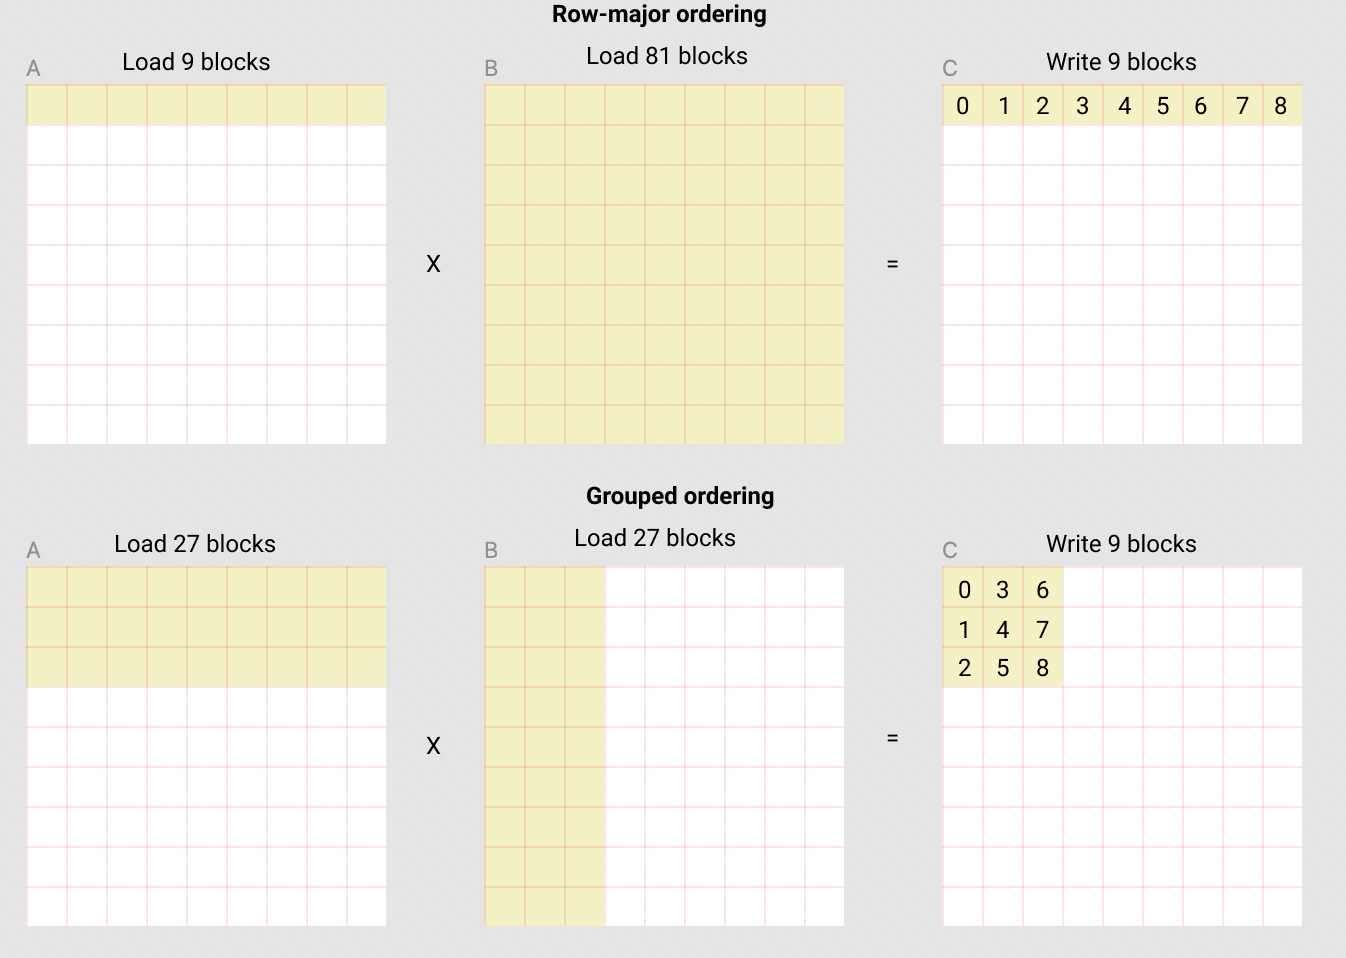

在实践中，这可以在某些硬件架构上提高我们的矩阵乘法内核的性能超过 10%（例如，在 A100 上从 220 TFLOPS 提高到 245 TFLOPS）。

## 最终结果

In [ ]:
import torch
import triton
import triton.language as tl

# 动态检测并设置当前可用的 GPU 设备。
DEVICE = triton.runtime.driver.active.get_active_torch_device()

# ---
# 整体概览
# 这是一个辅助函数，用于检查 Triton 当前运行的后端是否为 NVIDIA 的 CUDA 平台。
# ---
def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

# ---
# 整体概览
# 这是一个更具体的辅助函数，用于检查当前是否在 AMD 的 CDNA2 架构 GPU (例如 MI200系列) 上运行。
# 某些性能调优参数可能需要针对特定硬件架构进行调整。
# ---
def is_hip_cdna2():
    target = triton.runtime.driver.active.get_current_target()
    return target.backend == 'hip' and target.arch == 'gfx90a'

# ---
# 整体概览
# 这个函数定义并返回一个专门为 NVIDIA CUDA GPU 手动挑选的、性能良好的配置列表。
# `@triton.autotune` 装饰器会遍历这个列表中的每一个 `triton.Config` 对象，
# 测试其性能，并为给定的输入尺寸选择最快的一个配置。
# ---
def get_cuda_autotune_config():
    return [
        # 每个 triton.Config 代表一组要测试的元参数（meta-parameters）组合。
        # BLOCK_SIZE_M/N/K: 定义了矩阵分块的大小。
        # GROUP_SIZE_M: 用于 L2 缓存优化的组大小。
        # num_stages: 软件流水线的阶段数，用于隐藏内存延迟。
        # num_warps: 每个程序块（Block）使用的 Warp 数量。
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        # 针对 FP8 数据类型输入的良好配置
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4)
    ]

# ---
# 整体概览
# 这个函数返回一个专门为 AMD HIP 平台挑选的配置列表。
# 注意其参数与 CUDA 版本有差异，例如增加了 `matrix_instr_nonkdim`，这与 AMD 的矩阵指令有关。
# ---
def get_hip_autotune_config():
    sizes = [
        {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 6},
        {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 4},
        {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 6},
        {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 6},
        {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 4},
        {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 4},
        {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 4},
        {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 6},
    ]
    # 使用列表推导式为所有尺寸配置统一的 num_warps 和 num_stages。
    return [triton.Config(s | {'matrix_instr_nonkdim': 16}, num_warps=8, num_stages=2) for s in sizes]

# ---
# 整体概览
# 这是一个调度函数，它根据当前检测到的硬件平台（CUDA 或 HIP）返回相应的自动调优配置列表。
# ---
def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        return get_hip_autotune_config()

# ---
# 整体概览
# 这是一个高性能的、可自动调优的、支持激活函数融合的矩阵乘法 GPU 内核。
# 它实现了 C = A x B 的计算，并通过分块（Tiling）、分组（Grouping）和软件流水线等多种技巧来最大化性能。
# ---
# `@triton.autotune` 是一个强大的装饰器，它会自动测试 `configs` 列表中的所有配置。
# `key=['M', 'N', 'K']` 指定了触发自动调优的参数。只有当 M, N, K 的组合是第一次出现时，
# 才会运行所有配置来寻找最佳参数；后续对于相同的 M, N, K 调用，将直接使用缓存的最佳配置。
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # --- Kernel 参数 ---
        # 指向 A, B, C 矩阵在 DRAM 中起始位置的指针。
        a_ptr, b_ptr, c_ptr,
        # 矩阵的维度。
        M, N, K,
        # 步长（Stride）变量：表示在内存中沿着某个维度移动一个元素，指针需要增加多少。
        # 这使得内核可以处理非连续的张量（例如矩阵的切片）。
        stride_am, stride_ak,
        stride_bk, stride_bn,
        stride_cm, stride_cn,
        # 元参数（Meta-parameters）：这些值必须在编译时确定，因此用 `tl.constexpr` 标记。
        # 它们定义了内核的计算结构，是自动调优的对象。
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
        GROUP_SIZE_M: tl.constexpr,  # 用于 L2 缓存优化的分组大小
        ACTIVATION: tl.constexpr    # 用于激活函数融合的开关
):
    """Kernel for computing the matmul C = A x B."""
    # --- 1. 程序ID到计算块的映射（L2缓存优化）---
    # 这里的映射策略不是简单的线性划分，而是采用“分组”策略来提升 L2 缓存的命中率。
    # 一个组内的程序块在 M 维度上是连续的，处理完一个组后，下一个组会跳到新的 M 维度区域。
    # 这使得在处理一个组时，B 矩阵的相应数据块更有可能保留在 L2 缓存中被重复利用。
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)  # M 维度上的总块数
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)  # N 维度上的总块数
    num_pid_in_group = GROUP_SIZE_M * num_pid_n # 每个组包含的程序ID数量
    group_id = pid // num_pid_in_group # 计算当前 pid 属于哪个组
    first_pid_m = group_id * GROUP_SIZE_M # 计算该组的起始 M 方向块索引
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M) # 处理边界情况，最后一个组可能不满
    # 计算当前程序最终负责的 C 矩阵块的 M 和 N 方向索引
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # --- 2. 编译器提示 ---
    # `tl.assume` 是一种给编译器的提示，告诉它某些值（如步长）的已知属性（如大于0）。
    # 这可以帮助编译器进行更激进的优化，尤其是在地址计算方面。
    tl.assume(pid_m >= 0)
    # ... 其他 assume ...

    # --- 3. 创建初始指针块 ---
    # 计算当前程序块需要处理的 A 和 B 矩阵的第一个分块（Tile）的指针。
    # `tl.arange` 创建块内的偏移量，通过广播和步长计算，得到一个2D的指针块。
    # `a_ptrs` 是一个 [BLOCK_SIZE_M, BLOCK_SIZE_K] 的指针块。
    # `b_ptrs` 是一个 [BLOCK_SIZE_K, BLOCK_SIZE_N] 的指针块。
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # --- 4. 主循环：沿 K 维度累加 ---
    # 初始化一个累加器块，使用 float32 以保证计算过程中的精度。
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    # 循环遍历 K 维度，每次处理一个 `BLOCK_SIZE_K` 大小的块。
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # 加载 A 和 B 的当前块。使用掩码（mask）来处理 K 维度边界，
        # 防止因 K 不是 BLOCK_SIZE_K 的整数倍而导致的越界读取。
        # `other=0.0` 确保越界部分的值为0，不影响点积结果。
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # 执行核心的点积（dot product）运算，并将结果累加到累加器中。
        accumulator = tl.dot(a, b, accumulator)
        # 将 A 和 B 的指针向前移动到 K 维度的下一个块。
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
        
    # --- 5. 融合激活函数 ---
    # 在累加器仍然是 float32 格式（且数据仍在快速的SRAM中）时，直接应用激活函数。
    # 这是 Triton 实现高性能融合操作的关键所在。
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    # 将高精度的累加器结果转换回目标数据类型（例如 float16）。
    c = accumulator.to(tl.float16)

    # --- 6. 写回结果 ---
    # 计算 C 矩阵中对应块的偏移量和指针。
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    # 创建一个2D掩码，以防止因 M 或 N 不是块大小的整数倍而导致的越界写入。
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    # 将最终计算出的 C 矩阵块写回到 DRAM 中，并应用掩码。
    tl.store(c_ptrs, c, mask=c_mask)

# ---
# 整体概览
# 这是一个被 JIT 编译的、用于 Leaky ReLU 激活函数的辅助内核。
# 它可以被主内核 `matmul_kernel` 通过 `ACTIVATION` 元参数调用，实现计算融合。
# ---
@triton.jit
def leaky_relu(x):
    # `tl.where` 是 Triton 中的三元运算符，等同于 `condition ? x : y`。
    return tl.where(x >= 0, x, 0.01 * x)

我们现在可以创建一个便利的包装函数，该函数只接受两个输入张量，并且（1）检查任何形状约束；（2）分配输出；（3）启动上述内核。

In [ ]:
def matmul(a, b, activation=""):
    # --- 1. 输入校验 ---
    # 检查两个矩阵的内部维度是否匹配（A的列数必须等于B的行数），这是矩阵乘法的基本要求。
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    # 检查矩阵 A 是否为内存连续的（contiguous）。这个内核的指针计算依赖于连续的内存布局。
    # 虽然使用步长（stride）可以处理非连续张量，但这个发射器为了简化，直接要求输入是连续的。
    assert a.is_contiguous(), "Matrix A must be contiguous"
    # 为了代码清晰，解包获取矩阵的各个维度。
    M, K = a.shape
    K, N = b.shape
    
    # --- 2. 内存分配 ---
    # 预先在 GPU 设备上为输出矩阵 `c` 分配一块空的内存空间。
    # 其数据类型被设置为 float16，与我们的内核计算结果的类型保持一致。
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    
    # --- 3. 启动网格定义 ---
    # 定义一个 lambda 函数来计算启动网格（Launch Grid）的大小。
    # 网格的大小决定了要启动多少个并行的程序实例（Program）。
    # `triton.cdiv(M, META['BLOCK_SIZE_M'])` 计算 M 维度上需要多少个程序块。
    # `triton.cdiv(N, META['BLOCK_SIZE_N'])` 计算 N 维度上需要多少个程序块。
    # 将两者相乘，得到覆盖整个输出矩阵 C 所需的总程序块数量。
    # 注意，这里最终创建的是一个一维的启动网格，程序实例的总数就是这个乘积。
    # 内核内部的逻辑 (`pid = tl.program_id(axis=0)`) 会接收这个一维的 `pid`，然后再将其手动解码成二维的块索引 `(pid_m, pid_n)`。
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    
    # --- 4. 内核调用 ---
    # `matmul_kernel[grid]` 是 Triton 的特殊语法，用计算好的 `grid` 来配置并准备启动内核。
    # 这一步会触发自动调优（如果 M, N, K 的组合是首次出现）。
    matmul_kernel[grid](
        # 传入 A, B, C 三个张量，Triton 会自动将它们转换为指针。
        a, b, c,
        # 传入矩阵的维度 M, N, K。
        M, N, K,
        # 传入 A 矩阵的步长。`a.stride(0)` 表示在内存中移动到下一行需要跳过的元素数。
        a.stride(0), a.stride(1),
        # 传入 B 矩阵的步长。
        b.stride(0), b.stride(1),
        # 传入 C 矩阵的步长。
        c.stride(0), c.stride(1),
        # 以关键字参数的形式，传入需要融合的激活函数名称。
        # 这个值会作为 `constexpr` 传递给内核，用于编译时决策。
        ACTIVATION=activation
    )
    
    # --- 5. 返回结果 ---
    # 由于 GPU 执行是异步的，这个函数会立即返回输出张量 `c` 的句柄，
    # 而此时 GPU 可能仍在后台执行计算。
    return c

## 单元测试

我们可以将自定义的矩阵乘法操作与原生的 torch 实现（即 cuBLAS）进行测试。

In [ ]:
# --- 测试一：FP16 输入 ---

# 设置随机数种子为0。这确保了每次运行代码时，生成的“随机”张量 a 和 b 都是完全一样的。
# 这对于保证测试的可复现性至关重要。
torch.manual_seed(0)
# 在指定的 GPU 设备上，创建两个 512x512 大小、数据类型为 float16 的随机矩阵。
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)

# 调用我们自己编写的、经过 Triton 优化的 matmul 函数。
triton_output = matmul(a, b)
# 调用 PyTorch 官方内置的 matmul 函数，其结果作为参考标准。
torch_output = torch.matmul(a, b)
# 打印两个函数的输出结果，方便手动观察。
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")

# --- 精度容忍度设置与对比 ---
# 为 AMD CDNA2 架构的设备设置一个更大的相对容忍度（rtol）。
# 这是因为这些设备在执行 fp16 运算时会使用较低的精度，并且会将非规格化（denormal）的数值清零。
# 这种硬件层面的差异会导致其计算结果与NVIDIA GPU或标准IEEE 754浮点数有些许偏差。
rtol = 1e-2 if is_hip_cdna2() else 0
# `torch.allclose` 是比较两个浮点数张量是否“足够接近”的标准函数。
# `atol`: 绝对容忍度。 `rtol`: 相对容忍度。
# 如果两个张量对应元素之间的差异满足 `|a - b| <= atol + rtol * |b|`，则认为它们是接近的。
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=rtol):
    # 如果结果匹配，打印成功信息。
    print("✅ Triton and Torch match")
else:
    # 如果结果不匹配，打印失败信息。
    print("❌ Triton and Torch differ")


# --- 测试二：FP8 输入 (如果支持) ---

# `hasattr` 检查当前的 PyTorch 版本是否包含 `float8_e5m2` 这个属性，从而判断是否支持FP8。
TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
# 仅当 PyTorch 支持 FP8 并且当前后端是 CUDA 时，才执行此测试。
# (因为 FP8 最初主要在 NVIDIA Hopper 及更新架构上得到支持)。
if TORCH_HAS_FP8 and is_cuda():
    # 同样设置随机数种子以保证复现性。
    torch.manual_seed(0)
    # 创建 fp16 的原始输入张量。
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    # 将输入张量 a 转换为 float8_e5m2 数据类型。
    a = a.to(torch.float8_e5m2)
    # 为了提高某些 matmul 算法的效率，可以预先转置矩阵 b。
    # 这可以使内存访问模式更佳（例如，将非连续的跨列访问变为连续的跨行访问）。
    b = b.T
    # 将转置后的矩阵 b 也转换为 float8 类型。
    b = b.to(torch.float8_e5m2)
    # 使用 FP8 输入调用我们的 Triton 内核。
    triton_output = matmul(a, b)
    # 为了进行比较，我们将 FP8 输入转换回 FP16，然后使用 PyTorch 的 FP16 matmul 计算。
    # 这是因为原生支持 FP8 的 `torch.matmul` 可能不是所有版本都稳定，
    # 并且这样做可以提供一个在通用数据类型上的可靠参考基准。
    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))
    print(f"triton_output_with_fp8_inputs={triton_output}")
    print(f"torch_output_with_fp8_inputs={torch_output}")
    # 使用 `torch.allclose` 进行比较。注意，这里的绝对容忍度 `atol` 设置得更大（0.125）。
    # 这是因为 FP8 是一种精度非常低的数据类型，其计算结果自然会带来比 FP16更大的舍入误差。
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

## 基准

### 方阵性能

我们现在可以将我们的内核性能与 cuBLAS 或 rocBLAS 的性能进行比较。这里我们专注于方阵，但您可以根据需要调整此脚本，以基准测试任何其他矩阵形状。

In [ ]:
# --- 1. 动态构建基准测试配置 ---

# 根据当前硬件后端，动态确定用作参考标准的底层库名称。
ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'
# 创建一个空列表，用于存放一个或多个基准测试的配置对象。
configs = []
# 通过循环来创建两种测试场景：一次是常规的 FP16 输入，一次是 FP8 输入。
for fp8_inputs in [False, True]:
    # 如果是 FP8 测试场景，但当前环境不支持 FP8，则跳过本次循环，不生成该测试配置。
    if fp8_inputs and (not TORCH_HAS_FP8 or not is_cuda()):
        continue
    # 为一种场景（FP16 或 FP8）创建一个 `Benchmark` 配置对象，并将其添加到列表中。
    configs.append(
        triton.testing.Benchmark(
            # x_names: 定义图表的 x 轴。这里 M, N, K 将会同步变化。
            x_names=["M", "N", "K"],
            # x_vals: 为 M, N, K 提供一系列同步变化的取值，用于测试方阵的性能。
            x_vals=[128 * i for i in range(2, 33)],
            # line_arg: 定义用于区分图中不同曲线的参数。
            line_arg="provider",
            # line_vals: 根据是否为 FP8 测试，动态设置对比的实现方。
            # 如果是 FP8 测试，由于 `torch.matmul` 不原生支持，我们只评估 Triton 自身性能。
            # 如果是 FP16 测试，则将 Triton 与参考库（cuBLAS/rocBLAS）进行对比。
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],
            # line_names: 图例中每条曲线的显示名称。
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton"],
            # styles: 每条曲线的视觉样式。
            styles=[("green", "-"), ("blue", "-")],
            # ylabel: y 轴的标签。这次使用 TFLOPS 作为性能指标。
            ylabel="TFLOPS",
            # plot_name: 根据场景动态生成图表标题和文件名。
            plot_name="matmul-performance-" + ("fp16" if not fp8_inputs else "fp8"),
            # args: 将 `fp8_inputs` 标志作为固定参数传递给 `benchmark` 函数。
            args={"fp8_inputs": fp8_inputs},
        ))

# --- 2. 定义基准测试函数 ---

# `@triton.testing.perf_report` 装饰器接收一个配置对象的列表。
# 它会依次执行列表中的每一个 `Benchmark` 配置，生成多个图表。
@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    # 创建随机的输入张量 a 和 b。
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    # 如果是 FP8 测试场景，则将输入张量转换为 FP8 类型。
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        # 预转置 b 以提高效率。
        b = b.T
        b = b.to(torch.float8_e5m2)
    
    quantiles = [0.5, 0.2, 0.8]
    # 根据 `provider` 的值，选择要进行基准测试的函数。
    if provider == ref_lib.lower():
        # 如果是参考库，我们通过调用 `torch.matmul` 来间接使用 cuBLAS 或 rocBLAS。
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        # 如果是 'triton'，则调用我们自己优化的 `matmul` 函数。
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
        
    # 定义一个 lambda 函数，用于将测得的时间（毫秒, ms）转换为计算吞吐量（TFLOPS）。
    # 计算公式：(总浮点运算次数 / 10^12) / (总时间 / 10^3)。
    # 矩阵乘法 (M,K) x (K,N) 的总浮点运算次数约等于 2 * M * N * K。
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    # 返回中位数、最差情况和最好情况下的性能，用于绘制带误差区间的性能曲线。
    return perf(ms), perf(max_ms), perf(min_ms)

# --- 3. 执行基准测试 ---

# 调用 `.run()` 方法来启动 `configs` 列表中定义的所有基准测试。
benchmark.run(show_plots=True, print_data=True)

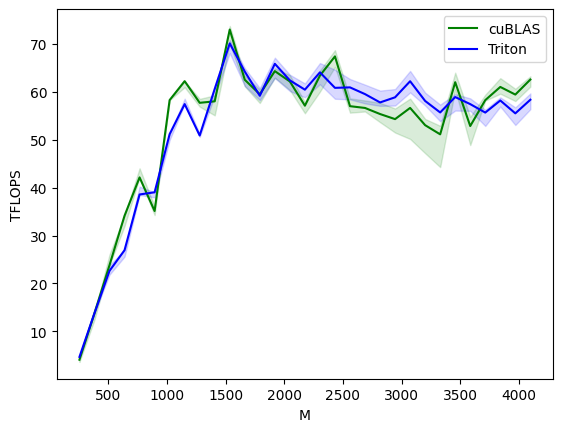